In [192]:
import requests
import overpy
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import json
from shapely.geometry import Polygon, LineString, LinearRing
from h3 import h3
import matplotlib.pyplot as plt
import contextily as ctl
import mplleaflet
from shapely.ops import polygonize



In [193]:
op_api = overpy.Overpass()

op_query = '[out:json]; area[name="Alps"]->.alps; rel(pivot.alps); out geom;'
op_response = op_api.query(op_query)

In [194]:
alps_relation = op_response.relations[0]

In [195]:
linestrings_from_ways = []
for member in alps_relation.members:
    nodes = []
    for geometry in member.geometry:
        nodes.append((geometry.lon, geometry.lat))
    linestrings_from_ways.append(LineString(nodes)) 

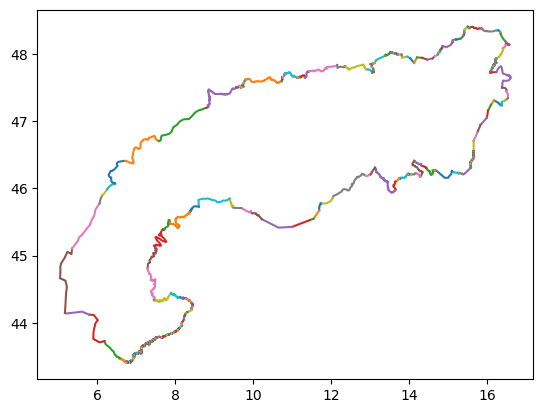

In [196]:
fig, ax = plt.subplots(1)

for line in linestrings_from_ways:
    ax.plot(*line.xy)

<Axes: >

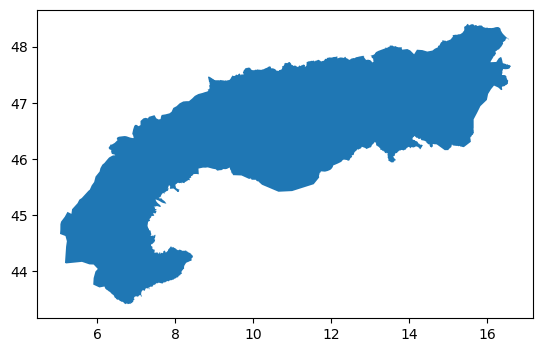

In [197]:
alps_polygon = polygonize(linestrings_from_ways)[0]

gdf_alps_boundary = gpd.GeoDataFrame(geometry=[alps_polygon],crs=4326)

fig, ax = plt.subplots(1)
gdf_alps_boundary.plot(ax = ax)

In [198]:
alps_boundary_geojson_filename = '../data/alps_boundary.geojson'
gdf_alps_boundary.to_file(alps_boundary_geojson_filename, driver="GeoJSON")

In [207]:
alps_geojson = json.load(open(alps_boundary_geojson_filename))

alps_geometry_geojson = alps_geojson["features"][0]["geometry"]

h3_resolution = 6

h3_indices = h3.polyfill(alps_geometry_geojson, res=h3_resolution)

df_alps_h3 = pd.DataFrame(h3_indices, columns=["h3_index"])

In [200]:
df_alps_h3["geometry"] = df_alps_h3["h3_index"].apply(h3.h3_to_geo_boundary)

In [201]:
def swap_lon_lat(coords_input):
    coords_output = []
    for coord in coords_input:
        coords_output.append([coord[1], coord[0]])
    return coords_output

In [202]:
# df_alps_h3["geometry"] = df_alps_h3.geometry.apply(swap_lon_lat)

In [203]:
df_alps_h3["geometry"] = df_alps_h3.geometry.apply(Polygon)


<Axes: >

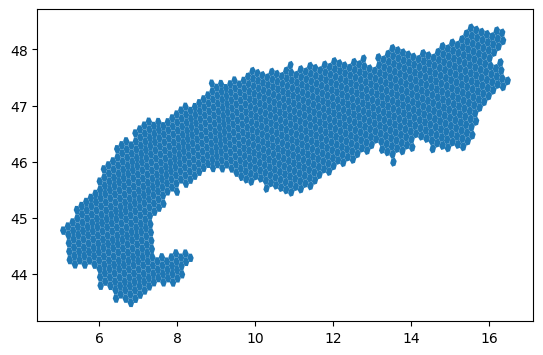

In [204]:
gdf_alps_h3 = gpd.GeoDataFrame(geometry = df_alps_h3.geometry, crs = 4326)
gdf_alps_h3.index = df_alps_h3.h3_index
gdf_alps_h3.plot()

In [205]:
alps_h3_discretized_filename = "../data/alps_h3.geojson"
gdf_alps_h3.to_file(alps_h3_discretized_filename, driver="GeoJSON")

<Axes: >

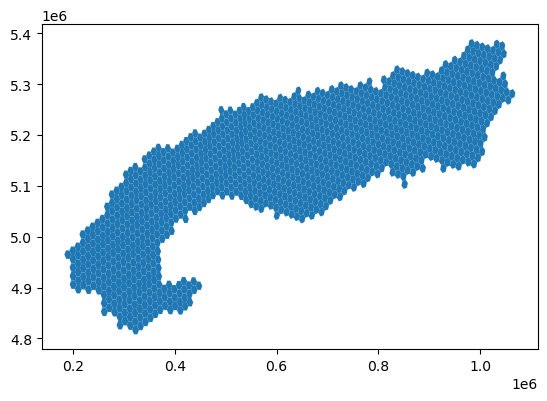

In [206]:
utm_epsg_code = 32632

gdf_alps_h3_utm = gdf_alps_h3.to_crs(crs=utm_epsg_code)

gdf_alps_h3_utm.plot()